In [2018]:
import pandas as pd # type: ignore
import numpy as np # type: ignore
import matplotlib.pyplot as plt # type: ignore
import matplotlib.dates as mdates # type: ignore
import matplotlib.ticker as ticker # type: ignore
from matplotlib.axis import Axis # type: ignore
import datetime as dt 

import time
start = time.time()

In [2019]:
def get_data2(filename):    
    data = pd.read_csv(filename) #, names=["Interval","kWh"])
    return data
    
def conso_byhour(day):
    ''' 
    display conso by hour for the chosen day
    '''
    conso_day=conso_data[conso_data['days']==day].copy()  # type: ignore # no more error
    conso_day['heure']=conso_day['dates'].apply(lambda x: str(x.hour)+':'+str(x.minute) +':'+str(x.second))

    conso_hours = conso_day.copy()
    conso_hours['hours']= conso_hours['dates'].dt.strftime('%H')
    conso_hours#.info()
    # group by hour
    groupedbyhour = conso_hours[['hours','kWh']].groupby('hours', sort=False)
    groupedbyhour.count()
    len(groupedbyhour)
    x = np.arange(1,len(groupedbyhour)+1)

    #groupedbyhour.count().plot(grid=True,xticks=x)
    plt.figure(figsize=(12, 8),facecolor='darkcyan')
    values = groupedbyhour.count().kWh
    #ax = plt.bar(x,groupedbyhour.count().kWh)
    ax = values.plot(kind="bar",color='green',width=.8)
    ax.set_facecolor('antiquewhite')
    #plt.grid()
    plt.tight_layout()
    plt.title(f'Conso by hour (W) - {day}')
    plt.xlim(-1,len(x)+1)
    plt.xticks(rotation=30);
    
    rects = ax.patches

    # Make some labels.
    labels = [f"{i}" for i in values]
    
    for rect, label in zip(rects, labels):
        height = rect.get_height()
        ax.text(
            rect.get_x() + rect.get_width() / 2, height + 5, label, ha="center", va="bottom",
            fontfamily='calibri', fontsize=16, fontweight='bold', color='blue'
        )
    
    
def from_csv(csv_file): 
    ''' save data to csv  '''
    df = pd.read_csv(csv_file)
    return df
    
def to_csv(csv_file, df):
    ''' read data from csv'''
    df.to_csv(csv_file, index=False)


### conso.csv créé par pi4 node-red onglet Linky
#### création de conso_data 

In [2020]:
conso_file = r"\\192.168.0.175\pihome\Documents\conso2.csv"
conso_data = get_data2(conso_file)
conso_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2153431 entries, 0 to 2153430
Data columns (total 2 columns):
 #   Column    Dtype  
---  ------    -----  
 0   Interval  int64  
 1   kWh       float64
dtypes: float64(1), int64(1)
memory usage: 32.9 MB


# reduce to 1 million events

In [2021]:
conso_data = conso_data.tail(1000000)
conso_data.reset_index(drop=True, inplace=True)
conso_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000000 entries, 0 to 999999
Data columns (total 2 columns):
 #   Column    Non-Null Count    Dtype  
---  ------    --------------    -----  
 0   Interval  1000000 non-null  int64  
 1   kWh       1000000 non-null  float64
dtypes: float64(1), int64(1)
memory usage: 15.3 MB


### conversion Interval -> kWh

In [2022]:
conso_data['sec']=conso_data['Interval']/1000
conso_data

,Interval,kWh,sec
0,33962,0.11,33.962
1,33967,0.10,33.967
2,34032,0.10,34.032
3,33949,0.11,33.949
4,34113,0.10,34.113
...,...,...,...
999995,25185,0.14,25.185
999996,25056,0.14,25.056
999997,25072,0.14,25.072
999998,24486,0.15,24.486


In [2023]:
conso_data['Wh']=3600000/conso_data['Interval']


### Cumul Total interval

In [2024]:
conso_data['cumul(ms)']=conso_data['Interval'].cumsum(axis=0)

In [2025]:
l=len(conso_data)-1
cumtime= int(conso_data._get_value(l,'cumul(ms)')*1000)  # convert to microseconds
cumtime

26138555551000

### Calcul de la date de base = now - cumul_interval

In [2026]:
from datetime import datetime, timedelta
now = datetime.now()
# conso.csv dynamique
base = now - timedelta(microseconds=cumtime)
base  # date de début

datetime.datetime(2024, 6, 26, 8, 22, 17, 752755)

In [2027]:
conso_data['cumul(ms)'][conso_data['cumul(ms)'].isna()==True]

Series([], Name: cumul(ms), dtype: int64)

In [2028]:
conso_data.iloc[0]


Interval     33962.000000
kWh              0.110000
sec             33.962000
Wh             106.000824
cumul(ms)    33962.000000
Name: 0, dtype: float64

### Recréer les dates à partir des cumuls par impulsion


In [2029]:
base

datetime.datetime(2024, 6, 26, 8, 22, 17, 752755)

## créer les dates

In [2030]:
# create column 'dates' with time cumulated time from base
conso_data['dates'] = [base + dt.timedelta(microseconds=t*1000) for t in conso_data['cumul(ms)']]
conso_data['dates']

0        2024-06-26 08:22:51.714755
1        2024-06-26 08:23:25.681755
2        2024-06-26 08:23:59.713755
3        2024-06-26 08:24:33.662755
4        2024-06-26 08:25:07.775755
                    ...            
999995   2025-04-24 21:03:14.727755
999996   2025-04-24 21:03:39.783755
999997   2025-04-24 21:04:04.855755
999998   2025-04-24 21:04:29.341755
999999   2025-04-24 21:04:53.303755
Name: dates, Length: 1000000, dtype: datetime64[ns]

### create column 'days' avec format 'dd/mm/yy'


In [2031]:
conso_data['days']= [d.strftime('%d/%m/%y') for d in conso_data['dates']]    
#[str(d.month)+'-'+str(d.day) for d in conso_data['dates']]
conso_data

,Interval,kWh,sec,Wh,cumul(ms),dates,days
0,33962,0.11,33.962,106.000824,33962,2024-06-26 08:22:51.714755,26/06/24
1,33967,0.10,33.967,105.985221,67929,2024-06-26 08:23:25.681755,26/06/24
2,34032,0.10,34.032,105.782793,101961,2024-06-26 08:23:59.713755,26/06/24
3,33949,0.11,33.949,106.041415,135910,2024-06-26 08:24:33.662755,26/06/24
4,34113,0.10,34.113,105.531616,170023,2024-06-26 08:25:07.775755,26/06/24
...,...,...,...,...,...,...,...
999995,25185,0.14,25.185,142.942228,26138456975,2025-04-24 21:03:14.727755,24/04/25
999996,25056,0.14,25.056,143.678161,26138482031,2025-04-24 21:03:39.783755,24/04/25
999997,25072,0.14,25.072,143.586471,26138507103,2025-04-24 21:04:04.855755,24/04/25
999998,24486,0.15,24.486,147.022789,26138531589,2025-04-24 21:04:29.341755,24/04/25


### save conso_data with dates

In [2032]:
#to_csv(r'../conso_data_with_dates.csv',conso_data)

# tranche journalière


In [2033]:
now = datetime.now()
month = now.month
year = now.year
date = now.day
today = now.strftime('%d/%m/%y')    #str(now.month)+'-'+str(now.day)
here = now.strftime('%H:%M:%S')
today, date, month, year, here

('24/04/25', 24, 4, 2025, '21:05:43')

In [2034]:
conso_day = conso_data[conso_data['days']==today]
# save to file
filename='conso_jour.csv'
conso_day.to_csv(filename)
filename='../conso_jour.csv'
conso_day.to_csv(filename)

In [2035]:
conso_day.info()


<class 'pandas.core.frame.DataFrame'>
Index: 3190 entries, 996810 to 999999
Data columns (total 7 columns):
 #   Column     Non-Null Count  Dtype         
---  ------     --------------  -----         
 0   Interval   3190 non-null   int64         
 1   kWh        3190 non-null   float64       
 2   sec        3190 non-null   float64       
 3   Wh         3190 non-null   float64       
 4   cumul(ms)  3190 non-null   int64         
 5   dates      3190 non-null   datetime64[ns]
 6   days       3190 non-null   object        
dtypes: datetime64[ns](1), float64(3), int64(2), object(1)
memory usage: 199.4+ KB


In [2036]:
end = time.time()
print(end - start)

56.27095341682434


### grouped by days

In [2037]:
# group by day
grouped = conso_data[['days','kWh']].groupby('days', sort=False)
'''conso_graph=[]
for name, group in grouped:
    if name=='01/04/2024':print(group)
    #print("\n", name, len(group)/1000)
    conso_graph.append((name,len(group)/1000))'''
#grouped
# count elements in each group => conso in watts => convert to kW
df_grp = grouped.count()/1000



In [2038]:
data = list(df_grp['kWh'])
print(data)

[1.963, 2.993, 2.085, 2.084, 2.087, 2.081, 2.086, 2.087, 2.076, 2.082, 2.079, 3.56, 3.194, 3.388, 3.865, 3.518, 3.873, 3.532, 3.528, 3.755, 3.49, 3.397, 3.271, 3.472, 3.294, 3.721, 3.693, 3.556, 3.621, 3.407, 3.256, 3.175, 2.85, 3.056, 3.673, 3.753, 3.836, 3.015, 3.331, 3.353, 3.499, 3.66, 3.617, 3.535, 3.801, 3.858, 3.674, 4.41, 4.257, 3.899, 3.899, 4.03, 3.81, 3.839, 3.708, 3.285, 3.926, 3.942, 4.443, 3.775, 4.123, 3.788, 3.966, 3.784, 3.958, 3.709, 3.6, 3.5, 3.683, 3.518, 4.128, 3.707, 3.44, 3.546, 3.256, 2.424, 1.795, 1.793, 1.793, 1.796, 2.489, 1.849, 1.787, 1.792, 1.79, 1.821, 1.822, 1.814, 1.817, 1.819, 1.818, 1.815, 1.813, 1.785, 1.787, 1.785, 1.786, 1.783, 1.796, 1.789, 1.789, 1.785, 1.796, 1.802, 1.796, 1.803, 1.796, 1.785, 1.79, 1.785, 1.79, 1.797, 1.791, 1.801, 1.803, 1.795, 1.8, 1.798, 2.813, 3.99, 3.645, 3.923, 3.087, 3.625, 3.981, 3.44, 3.401, 3.945, 3.342, 4.172, 3.082, 4.031, 3.141, 3.361, 3.505, 3.982, 3.304, 3.358, 3.825, 3.234, 3.551, 3.354, 3.85, 3.399, 3.859, 3.22

In [2039]:
# save to file
# import pickle
# path = r'kwh_mean.pkl'
# with open(path,'wb') as file:
#     pickle.dump(data, file)

In [2040]:
end = time.time()
print(end - start)

59.31331729888916


### plot function by day
#### show('dd/mm/yy')

In [2041]:
from matplotlib.ticker import (MultipleLocator, AutoMinorLocator) # type: ignore
def show(day,pltcolor='darkcyan',bgcolor="ivory"):
    conso_day=conso_data[conso_data['days']==day].copy()  # no more error
    conso_day['heure']=conso_day['dates'].apply(lambda x: str(x.hour)+':'+str(x.minute) +':'+str(x.second))
    #=[x.hour for x in conso_day['dates']]
    #print(conso_day)
    df = conso_day.set_index('heure')
    here = now.strftime('%H:%M:%S')
    conso_jour=len(df['kWh'])
    here, len(df)/1000, conso_jour

    # consommation d'une journée entière à partir de minuit
    # Set background color of the outer 
    # area of the plt
    #plt.figure(facecolor=fgcolor)
    fig, ax = plt.subplots(facecolor=pltcolor)
    
    major_ticks=300;minor_ticks=100
    ax.xaxis.set_major_locator(MultipleLocator(major_ticks))  # major ticks tous les 15 min
    ax.xaxis.set_minor_locator(MultipleLocator(minor_ticks))
    # the size of A4 paper
    fig.set_size_inches(10, 5)
    
    # set bg color
    ax.set_facecolor(bgcolor)
    plt.plot(df['kWh'])
    #plt.plot(conso_day['heure'],conso_day['kWh'])
    plt.title(f'Journée du {day} {here} : {conso_jour/1000} kwh')
    plt.grid()
    plt.xticks(rotation=30);


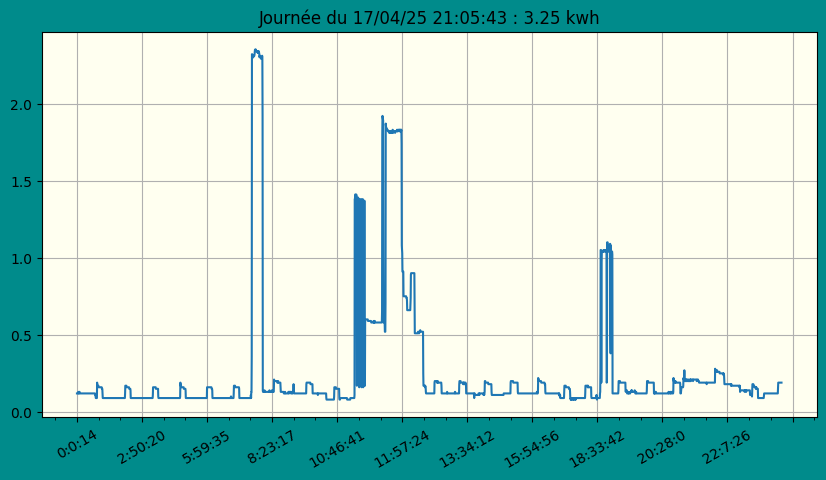

In [2042]:
show('17/04/25')

In [2043]:
end = time.time()
print(end - start)

60.8759560585022


### 1 kWh window in data of one day
#### df = conso_day

In [2044]:
df = conso_day
df

,Interval,kWh,sec,Wh,cumul(ms),dates,days
996810,17737,0.20,17.737,202.965552,26062679624,2025-04-24 00:00:17.376755,24/04/25
996811,17768,0.20,17.768,202.611436,26062697392,2025-04-24 00:00:35.144755,24/04/25
996812,17487,0.20,17.487,205.867216,26062714879,2025-04-24 00:00:52.631755,24/04/25
996813,17652,0.20,17.652,203.942896,26062732531,2025-04-24 00:01:10.283755,24/04/25
996814,17081,0.21,17.081,210.760494,26062749612,2025-04-24 00:01:27.364755,24/04/25
...,...,...,...,...,...,...,...
999995,25185,0.14,25.185,142.942228,26138456975,2025-04-24 21:03:14.727755,24/04/25
999996,25056,0.14,25.056,143.678161,26138482031,2025-04-24 21:03:39.783755,24/04/25
999997,25072,0.14,25.072,143.586471,26138507103,2025-04-24 21:04:04.855755,24/04/25
999998,24486,0.15,24.486,147.022789,26138531589,2025-04-24 21:04:29.341755,24/04/25


In [2045]:

def period(df=df, p=1):
    ''' 
    give the time of conso for a 1kWh window in a day
    p =  ordinal window ex: p=1 first kWh, p=2 second kWh ..
    df is the data from midnight, each entry is 1 watt
    as the length of df is the total conso in watt,
    we have len(df)/1000 = number of windows of 1 KWh since midnight
    the last window may not be 1000 watt long !
    '''
    if p==1:
        start = df.iloc[0].dates
    else:
        start = df.iloc[(p-1)*1000-1].dates
    if len(df)>p*1000:
        end = df.iloc[p*1000-1].dates
        conso = p*1000
    else:
        end = df.iloc[len(df)-1].dates
        conso = len(df) - (p-1)*1000
    period = end - start  # type timedelta
    hours = int(period / dt.timedelta(hours=1))
    mins = int(period / dt.timedelta(minutes=1)) - hours*60
    secs = int(period / dt.timedelta(seconds=1)) - hours*3600 - mins*60

    #df.iloc[1001:2000]['dates']#.tail(1)
    #print(period)
    print(f'{start}\t{end}\t{hours}h {mins}m {secs}s \t{conso}')


In [2046]:
df = conso_day
len(df)

3190

In [2047]:
period()  # first kWh
if len(df)>1000:
    period(p=2) # second period

2025-04-24 00:00:17.376755	2025-04-24 08:33:41.002755	8h 33m 23s 	1000
2025-04-24 08:33:41.002755	2025-04-24 12:58:06.018755	4h 24m 25s 	2000


In [2048]:
# mean of all instant conso
total_mean = conso_data[['kWh']].mean()
total_mean

kWh    0.292915
dtype: float64

In [2049]:
end = time.time()
print(end - start)

61.49553966522217


## mean for data grouped by days

In [2050]:
mean=(grouped.count()/1000).mean()
mean

kWh    3.30033
dtype: float64

In [2051]:
last=df_grp.iloc[-1]['kWh']
last

np.float64(3.19)

# conso by date


In [2052]:
# select day
day = today

#day = '16/08/24'
day

'24/04/25'

In [2053]:
df

,Interval,kWh,sec,Wh,cumul(ms),dates,days
996810,17737,0.20,17.737,202.965552,26062679624,2025-04-24 00:00:17.376755,24/04/25
996811,17768,0.20,17.768,202.611436,26062697392,2025-04-24 00:00:35.144755,24/04/25
996812,17487,0.20,17.487,205.867216,26062714879,2025-04-24 00:00:52.631755,24/04/25
996813,17652,0.20,17.652,203.942896,26062732531,2025-04-24 00:01:10.283755,24/04/25
996814,17081,0.21,17.081,210.760494,26062749612,2025-04-24 00:01:27.364755,24/04/25
...,...,...,...,...,...,...,...
999995,25185,0.14,25.185,142.942228,26138456975,2025-04-24 21:03:14.727755,24/04/25
999996,25056,0.14,25.056,143.678161,26138482031,2025-04-24 21:03:39.783755,24/04/25
999997,25072,0.14,25.072,143.586471,26138507103,2025-04-24 21:04:04.855755,24/04/25
999998,24486,0.15,24.486,147.022789,26138531589,2025-04-24 21:04:29.341755,24/04/25


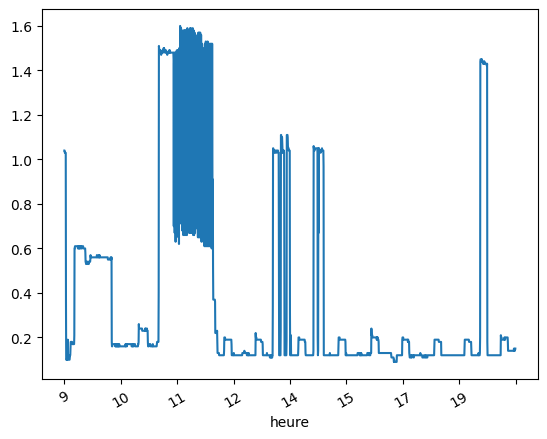

In [2054]:
conso_day=conso_data[conso_data['days']==day].copy()  # no more error
conso_day['heure']=conso_day['dates'].apply(lambda x: str(x.hour)) #+':'+str(x.minute) +':'+str(x.second))
#=[x.hour for x in conso_day['dates']]
df= conso_day.set_index('heure')
df.tail(2000)['kWh'].plot()
plt.xticks(rotation=30);
#conso_day['heure']


In [2055]:
end = time.time()
print(end - start)

62.623045921325684


### grouped by 'heure'

In [2056]:
conso_day.info()

<class 'pandas.core.frame.DataFrame'>
Index: 3190 entries, 996810 to 999999
Data columns (total 8 columns):
 #   Column     Non-Null Count  Dtype         
---  ------     --------------  -----         
 0   Interval   3190 non-null   int64         
 1   kWh        3190 non-null   float64       
 2   sec        3190 non-null   float64       
 3   Wh         3190 non-null   float64       
 4   cumul(ms)  3190 non-null   int64         
 5   dates      3190 non-null   datetime64[ns]
 6   days       3190 non-null   object        
 7   heure      3190 non-null   object        
dtypes: datetime64[ns](1), float64(3), int64(2), object(2)
memory usage: 224.3+ KB


In [2057]:
df

,Interval,kWh,sec,Wh,cumul(ms),dates,days
heure,,,,,,,
0,17737,0.20,17.737,202.965552,26062679624,2025-04-24 00:00:17.376755,24/04/25
0,17768,0.20,17.768,202.611436,26062697392,2025-04-24 00:00:35.144755,24/04/25
0,17487,0.20,17.487,205.867216,26062714879,2025-04-24 00:00:52.631755,24/04/25
0,17652,0.20,17.652,203.942896,26062732531,2025-04-24 00:01:10.283755,24/04/25
0,17081,0.21,17.081,210.760494,26062749612,2025-04-24 00:01:27.364755,24/04/25
...,...,...,...,...,...,...,...
21,25185,0.14,25.185,142.942228,26138456975,2025-04-24 21:03:14.727755,24/04/25
21,25056,0.14,25.056,143.678161,26138482031,2025-04-24 21:03:39.783755,24/04/25
21,25072,0.14,25.072,143.586471,26138507103,2025-04-24 21:04:04.855755,24/04/25


In [2058]:
# group by hour, df  = data of a chosen day
df_byhour = df[['days','kWh']].groupby('heure', sort=False)
df_byhour.groups

{'0': ['0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', ...], '1': ['1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '

In [2059]:
kwh_byhour = df_byhour['kWh']
kwh_byhour.count()

heure
0     125
1     104
2     104
3     101
4     102
5     101
6     113
7     179
8     125
9     148
10    277
11    389
12    135
13    170
14    185
15    132
16    138
17    126
18    129
19    130
20    165
21     12
Name: kWh, dtype: int64

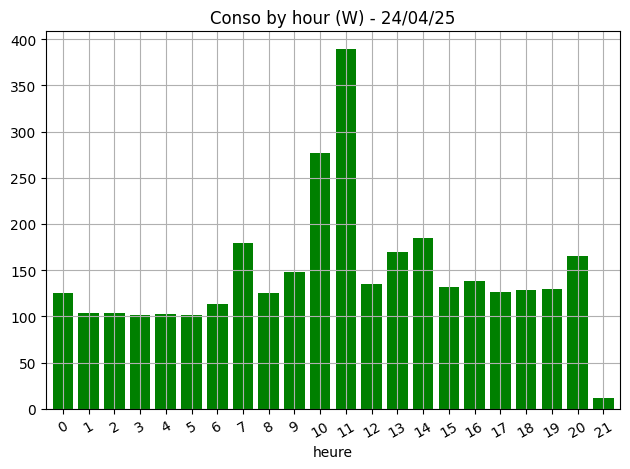

In [2060]:
kwh_byhour.count().plot(grid=True, kind='bar',color='green',width=.8)
plt.title(f'Conso by hour (W) - {day}')
plt.xticks(rotation=30);
plt.tight_layout()

In [2061]:
df_grp.info()

<class 'pandas.core.frame.DataFrame'>
Index: 303 entries, 26/06/24 to 24/04/25
Data columns (total 1 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   kWh     303 non-null    float64
dtypes: float64(1)
memory usage: 4.7+ KB


In [2062]:
# give the periods of 1 kwh in a day
period()

2025-04-24 00:00:17.376755	2025-04-24 08:33:41.002755	8h 33m 23s 	1000


In [2063]:

# premier kWh
if len(df)>1000:
    df.iloc[1000]['dates']
    df.iloc[0].dates, df.iloc[1000].dates
#df.dates.dt.time


In [2064]:

# save data
# df_grp.to_csv('df_grp.csv')
# df.to_csv('df.csv')
df_grp.to_csv('conso_day_from_20230821.csv')

#df.info()
#df_grp


In [2065]:
df_grp.mean()


kWh    3.30033
dtype: float64

In [2066]:
df_grp.head()


,kWh
days,
26/06/24,1.963
27/06/24,2.993
28/06/24,2.085
29/06/24,2.084
30/06/24,2.087


In [2067]:
df_grp.tail()


,kWh
days,
20/04/25,3.035
21/04/25,4.116
22/04/25,2.966
23/04/25,3.847
24/04/25,3.190


In [2068]:
end = time.time()
print(end - start)

65.351149559021


# plot les 100 derniers jours


In [2069]:
# moyenne sur 100 jours
df_grp.tail(100).mean()


kWh    3.55185
dtype: float64

Text(0.5, 1.0, 'Conso (kWh) last 100 days')

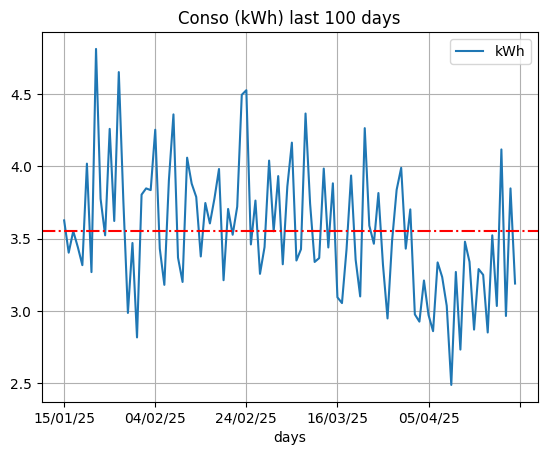

In [2070]:
# plot last 100 days
df_100 = df_grp.tail(100)
df_100.plot()
plt.axhline(y=np.nanmean(df_100),c='red', ls='-.',label='moyenne')
plt.grid()
plt.title('Conso (kWh) last 100 days')


In [2071]:
# max min during last 100 days
df_100.describe().loc[['min','max']]


,kWh
min,2.49
max,4.81


In [2072]:
end = time.time()
print(end - start)

66.13130331039429


In [2073]:
df_grp[-31:-1].index[0],df_grp[-31:-1].index[-5]

('25/03/25', '19/04/25')

In [2074]:
moyenne = df_grp.iloc[-31:-1].mean()
moyenne

kWh    3.2716
dtype: float64

Text(0.5, 1.0, 'Last month conso by day')

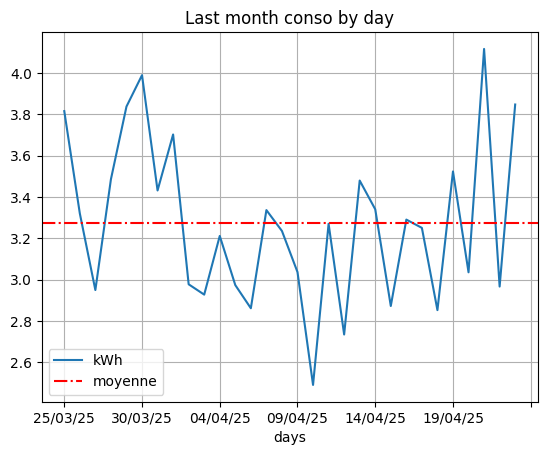

In [2075]:
# plot last monthh
df_grp.iloc[-31:-1].plot()
plt.axhline(y=np.nanmean(df_grp.iloc[-31:-1]),c='red', ls='-.',label='moyenne')
plt.legend()
plt.grid()
plt.title('Last month conso by day')


In [2076]:
month = df_grp.iloc[-31:-1]['kWh']
print('Max :',month.idxmax(), max(month))
print('Min :',month.idxmin(), min(month))

Max : 21/04/25 4.116
Min : 10/04/25 2.49


# Temps de conso par tranche de 1 kWh

In [2077]:

tranches = len(df)//1000
tranches+1


4

In [2078]:
# temps de conso par tranches de 1kwh
for p in range(1,tranches+2):  # les 5 tranches de kWh consommés
    if len(df)>(p-1)*1000:
        period(p=p)
# conso temps réel
here = now.strftime('%H:%M:%S')
conso_jour=len(df['kWh'])
here, len(df)/1000, conso_jour


2025-04-24 00:00:17.376755	2025-04-24 08:33:41.002755	8h 33m 23s 	1000
2025-04-24 08:33:41.002755	2025-04-24 12:58:06.018755	4h 24m 25s 	2000
2025-04-24 12:58:06.018755	2025-04-24 19:53:23.015755	6h 55m 16s 	3000
2025-04-24 19:53:23.015755	2025-04-24 21:04:53.303755	1h 11m 30s 	190


('21:05:43', 3.19, 3190)

In [2079]:
#add hours column for a chosen day
conso_hours = conso_day.copy()
conso_hours['hours']= conso_hours['dates'].dt.strftime('%H')
conso_hours.info()


<class 'pandas.core.frame.DataFrame'>
Index: 3190 entries, 996810 to 999999
Data columns (total 9 columns):
 #   Column     Non-Null Count  Dtype         
---  ------     --------------  -----         
 0   Interval   3190 non-null   int64         
 1   kWh        3190 non-null   float64       
 2   sec        3190 non-null   float64       
 3   Wh         3190 non-null   float64       
 4   cumul(ms)  3190 non-null   int64         
 5   dates      3190 non-null   datetime64[ns]
 6   days       3190 non-null   object        
 7   heure      3190 non-null   object        
 8   hours      3190 non-null   object        
dtypes: datetime64[ns](1), float64(3), int64(2), object(3)
memory usage: 249.2+ KB


In [2080]:
conso_hours['heure'], conso_hours['hours']

(996810     0
 996811     0
 996812     0
 996813     0
 996814     0
           ..
 999995    21
 999996    21
 999997    21
 999998    21
 999999    21
 Name: heure, Length: 3190, dtype: object,
 996810    00
 996811    00
 996812    00
 996813    00
 996814    00
           ..
 999995    21
 999996    21
 999997    21
 999998    21
 999999    21
 Name: hours, Length: 3190, dtype: object)

In [2081]:
end = time.time()
print(end - start)

67.3306884765625


# select number of days to display


In [2082]:
span = 30
#df_grp.tail(span)

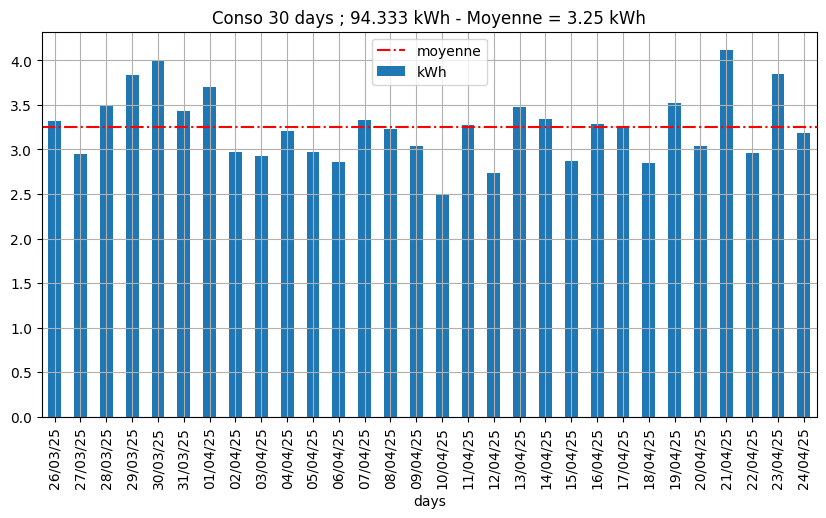

In [2083]:

# Plot the figure without labels
moy = round(np.nanmean(df_grp.tail(span).iloc[-31:-1]),2)
conso_mois = sum(df_grp.tail(span).iloc[-31:-1]['kWh'])
df_grp.tail(span).plot.bar(grid=True, figsize=(10, 5), layout='tight')
 
plt.title(f'Conso {span} days ; {conso_mois} kWh - Moyenne = {moy} kWh')
plt.axhline(y=moy,c='red', ls='-.',label='moyenne')
plt.legend()
plt.xticks(rotation=90);


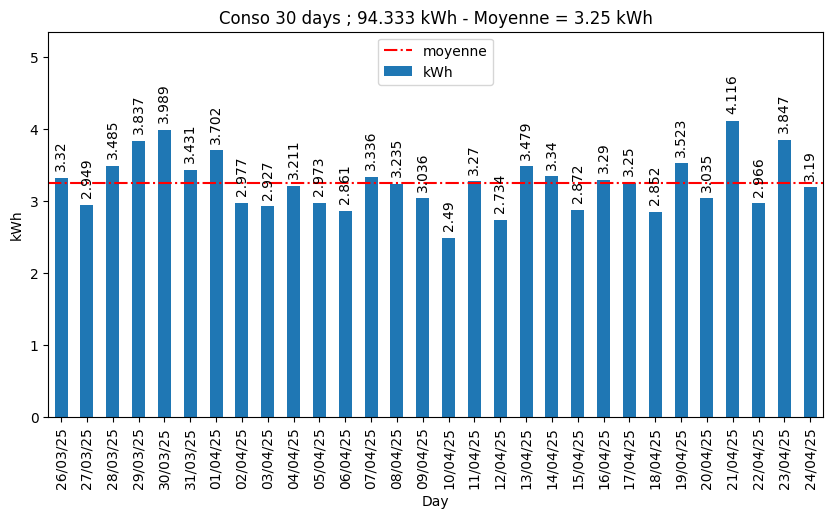

In [2084]:
# Plot the figure with labels.
x_labels = list(df_grp.tail(span)['kWh'])
#x_labels
#fig, ax = plt.subplots(figsize=(2, 2), facecolor='lightskyblue',layout='constrained')
ax = df_grp.tail(span).plot(kind="bar", figsize=(10, 5), layout='tight')
#ax.set_title(f"Conso by {span} days")
ax.set_title(f'Conso {span} days ; {conso_mois} kWh - Moyenne = {moy} kWh')
ax.set_xlabel("Day")
ax.set_ylabel("kWh")
ax.set_ymargin(0.3)
plt.axhline(y=moy,c='red', ls='-.',label='moyenne')
plt.legend()
#ax.set_xticklabels(x_labels)
#fig.tight_layout()

rects = ax.patches

# Make some labels.
labels = [x_labels[i] for i in range(len(x_labels))]

for rect, label in zip(rects, labels):
    height = rect.get_height()
    #print(height)
    ax.text(
        rect.get_x() + rect.get_width() / 2, height+.1, label, ha="center", va="bottom", rotation=90
    )

#plt.show()

In [2085]:
y_labels = df_grp.tail(span)['kWh']
y_labels

days
26/03/25    3.320
27/03/25    2.949
28/03/25    3.485
29/03/25    3.837
30/03/25    3.989
31/03/25    3.431
01/04/25    3.702
02/04/25    2.977
03/04/25    2.927
04/04/25    3.211
05/04/25    2.973
06/04/25    2.861
07/04/25    3.336
08/04/25    3.235
09/04/25    3.036
10/04/25    2.490
11/04/25    3.270
12/04/25    2.734
13/04/25    3.479
14/04/25    3.340
15/04/25    2.872
16/04/25    3.290
17/04/25    3.250
18/04/25    2.852
19/04/25    3.523
20/04/25    3.035
21/04/25    4.116
22/04/25    2.966
23/04/25    3.847
24/04/25    3.190
Name: kWh, dtype: float64

In [2086]:
x_labels=df_grp.tail(span).index
x_labels

Index(['26/03/25', '27/03/25', '28/03/25', '29/03/25', '30/03/25', '31/03/25',
       '01/04/25', '02/04/25', '03/04/25', '04/04/25', '05/04/25', '06/04/25',
       '07/04/25', '08/04/25', '09/04/25', '10/04/25', '11/04/25', '12/04/25',
       '13/04/25', '14/04/25', '15/04/25', '16/04/25', '17/04/25', '18/04/25',
       '19/04/25', '20/04/25', '21/04/25', '22/04/25', '23/04/25', '24/04/25'],
      dtype='object', name='days')

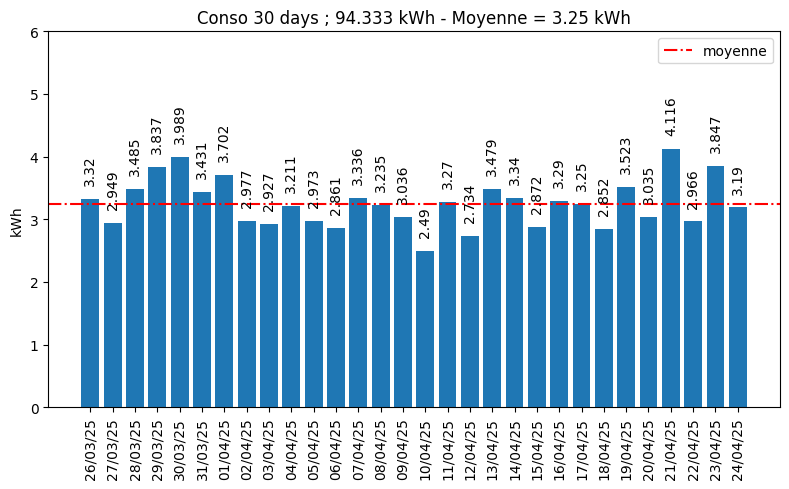

In [2087]:
# Plot the figure with labels
# using bar_label
# https://matplotlib.org/stable/gallery/lines_bars_and_markers/bar_label_demo.html#sphx-glr-gallery-lines-bars-and-markers-bar-label-demo-py
fig, ax = plt.subplots(figsize=(8, 5), layout='tight')
bar_container = ax.bar(x_labels, y_labels)
#ax.set_xticks(x_labels, rotation=45)
#ax.set_title(f'Conso {span} days ; {conso_mois} kWh - Moyenne = {moy} kWh')
ax.bar_label(bar_container, rotation=90, padding=10) #, fmt='{:,.0f}')
plt.axhline(y=moy,c='red', ls='-.',label='moyenne')
plt.legend()
ax.set(ylabel='kWh', title=f'Conso {span} days ; {conso_mois} kWh - Moyenne = {moy} kWh', ylim=(0, 6))
plt.xticks(rotation=90);


In [2088]:
end = time.time()
print(end - start)

71.1836769580841


In [2089]:
# figure manager

current=plt.get_current_fig_manager()
current.set_window_title('Conso by day')
#help(current.canvas)
#,facecolor='darkcyan')
#plt.style.use('fivethirtyeight')
#plt.style.use('ggplot')
#plt.style.use('dark_background')


<Figure size 640x480 with 0 Axes>

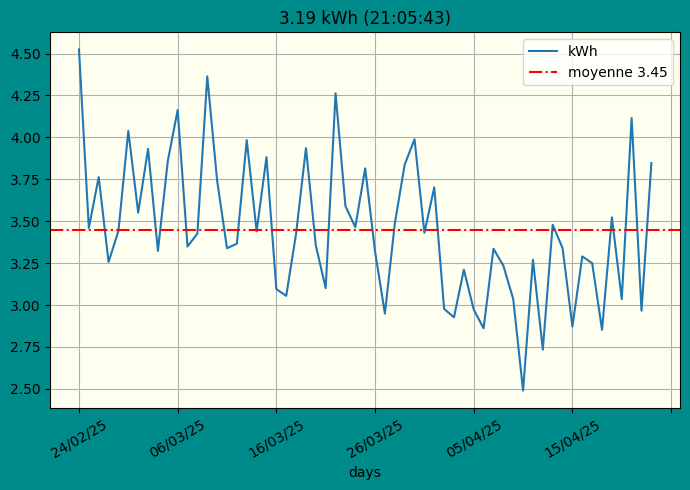

In [2090]:
# 2 last months
scan = 60
# pandas plot the day consos in the group
fig, ax = plt.subplots(facecolor='darkcyan', figsize=(7, 5), layout='tight')  # as argument
#or fig.patch.set_facecolor('darkcyan') # This changes the grey to white
ax.set_facecolor("ivory")

moy = round(np.nanmean(df_grp.iloc[-scan:-1]),2)
df_grp.iloc[-scan:-1].plot(grid=True,ax=ax, y=["kWh"])   #df.plot(x="Name", y=["Age", "Height(in cm)"], kind="bar", ax=ax)
plt.title(str(last)+' kWh ('+str(here)+')')
plt.axhline(y=moy,c='red', ls='-.',label=f'moyenne {moy}')
plt.legend()
plt.xticks(rotation=30);  # https://ipython.readthedocs.io/en/stable/interactive/tips.html


Text(0.5, 1.0, 'Variations journalières')

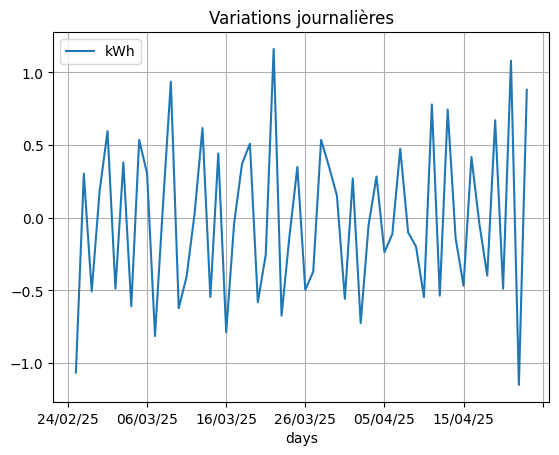

In [2091]:
# variations journalières sur 60 jours
df_grp.iloc[-60:-1].diff().plot(grid=True)
plt.title('Variations journalières')

In [2092]:
end = time.time()
print(end - start)

72.40289855003357


# Data from 21/08/23

In [2093]:
# add hours column for conso_data (from 21/08/2023)
conso_days = conso_data.copy()
conso_days['hours']= conso_days['dates'].dt.strftime('%H')

conso_days['months']= conso_days['dates'].dt.strftime('%Y-%m')
conso_days['day']= conso_days['dates'].dt.strftime('%d')
conso_days

,Interval,kWh,sec,Wh,cumul(ms),dates,days,hours,months,day
0,33962,0.11,33.962,106.000824,33962,2024-06-26 08:22:51.714755,26/06/24,08,2024-06,26
1,33967,0.10,33.967,105.985221,67929,2024-06-26 08:23:25.681755,26/06/24,08,2024-06,26
2,34032,0.10,34.032,105.782793,101961,2024-06-26 08:23:59.713755,26/06/24,08,2024-06,26
3,33949,0.11,33.949,106.041415,135910,2024-06-26 08:24:33.662755,26/06/24,08,2024-06,26
4,34113,0.10,34.113,105.531616,170023,2024-06-26 08:25:07.775755,26/06/24,08,2024-06,26
...,...,...,...,...,...,...,...,...,...,...
999995,25185,0.14,25.185,142.942228,26138456975,2025-04-24 21:03:14.727755,24/04/25,21,2025-04,24
999996,25056,0.14,25.056,143.678161,26138482031,2025-04-24 21:03:39.783755,24/04/25,21,2025-04,24
999997,25072,0.14,25.072,143.586471,26138507103,2025-04-24 21:04:04.855755,24/04/25,21,2025-04,24
999998,24486,0.15,24.486,147.022789,26138531589,2025-04-24 21:04:29.341755,24/04/25,21,2025-04,24


In [2094]:
end = time.time()
print(end - start)

122.09416365623474


In [2095]:
conso_grouped_by_month = conso_days[['day','hours','months','kWh']].groupby('months', sort=False)

conso_grouped_by_month.groups.keys()

dict_keys(['2024-06', '2024-07', '2024-08', '2024-09', '2024-10', '2024-11', '2024-12', '2025-01', '2025-02', '2025-03', '2025-04'])

# define month to show

<Axes: xlabel='day'>

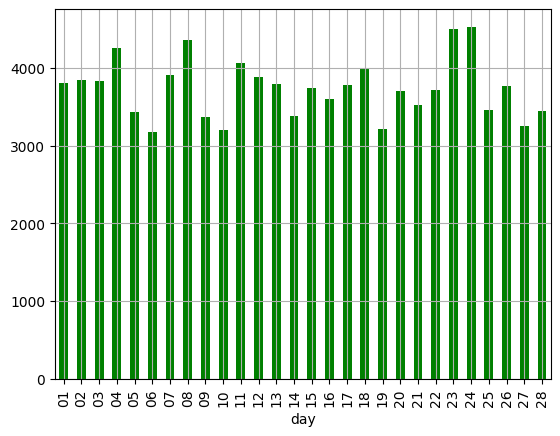

In [2096]:
month=conso_grouped_by_month.get_group('2025-02')
conso_grouped_by_month_day = month.groupby(['day'], sort=False)
conso_grouped_by_month_day['kWh'].count().plot(grid=True,kind='bar',color='green',width=.5)

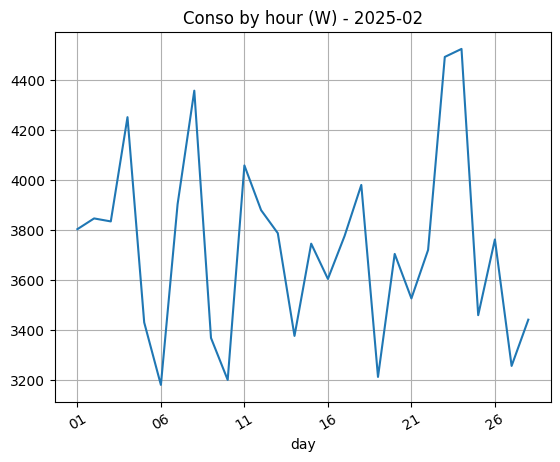

In [2097]:
conso_grouped_by_month_day['hours'].count().plot(grid=True)#, kind='bar', color='green', width=.8)
plt.title('Conso by hour (W) - '+month.iloc[0]['months'])
plt.xticks(rotation=30);


In [2098]:
conso_grouped_by_month_and_day = conso_days[['day','hours','months','kWh']].groupby(['months','day'], sort=False)

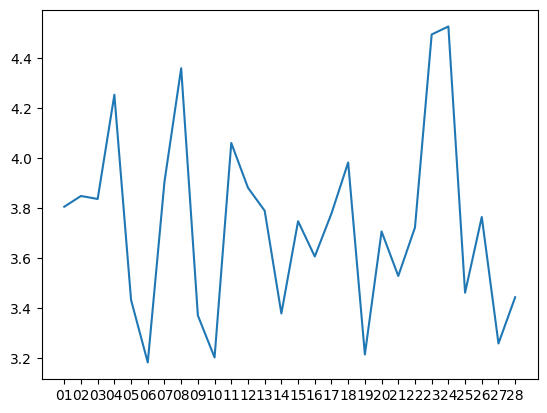

In [2099]:
plt.plot(conso_grouped_by_month_day['kWh'].count()/1000)

In [2100]:
# Example: Get data for January 2025 at hour '00'
#group = conso_grouped_by_month_and_day.get_group('2025-01')
#group

In [2101]:
# group.plot(grid=True, kind='bar', color='green', width=.8)
# plt.title('Conso by hour (W) - 2025-01')
# plt.xticks(rotation=30);


In [2102]:
# conso total par mois
conso_grouped_by_month.count()


,day,hours,kWh
months,,,
2024-06,11212,11212,11212
2024-07,99389,99389,99389
2024-08,117330,117330,117330
2024-09,69768,69768,69768
2024-10,73520,73520,73520
2024-11,108515,108515,108515
2024-12,113769,113769,113769
2025-01,113613,113613,113613
2025-02,104501,104501,104501


In [2103]:
# example groupby with apply
df = pd.DataFrame({'Animal': ['Falcon', 'Falcon',
                              'Parrot', 'Parrot'],
                   'Max Speed': [380., 370., 24., 26.]})
df.groupby("Animal", group_keys=True)[['Max Speed']].apply(lambda x: x)
      

Max Speed
Animal             
Falcon 0      380.0
       1      370.0
Parrot 2       24.0
       3       26.0

In [2104]:
# import pandas as pd
# df = pd.read_csv(r'../csv/only-bh-extreme-events-satellite.csv'
#                   ,index_col=[0,1,2,3,4]
#                   ,header=[0,1,2,3]
#                   ,skipinitialspace=True
#                   #,tupleize_cols=True
#                 ) 

# df.columns = pd.MultiIndex.from_tuples(df.columns)
# df.index.names
# index=df.columns.levels[0]
# index
# df_des = pd.DataFrame(
#                             index=df.columns.levels[0],
#                             columns=['count','mean','std','min','25','50','75','max']
#                          )
# df_des

In [2105]:
groupallbyday = conso_days[['days','hours','kWh']].groupby(['days'], sort=False)
groupallbyday[['kWh']].count()  #.apply(lambda x: x))

,kWh
days,
26/06/24,1963
27/06/24,2993
28/06/24,2085
29/06/24,2084
30/06/24,2087
...,...
20/04/25,3035
21/04/25,4116
22/04/25,2966


In [2106]:
conso_days

,Interval,kWh,sec,Wh,cumul(ms),dates,days,hours,months,day
0,33962,0.11,33.962,106.000824,33962,2024-06-26 08:22:51.714755,26/06/24,08,2024-06,26
1,33967,0.10,33.967,105.985221,67929,2024-06-26 08:23:25.681755,26/06/24,08,2024-06,26
2,34032,0.10,34.032,105.782793,101961,2024-06-26 08:23:59.713755,26/06/24,08,2024-06,26
3,33949,0.11,33.949,106.041415,135910,2024-06-26 08:24:33.662755,26/06/24,08,2024-06,26
4,34113,0.10,34.113,105.531616,170023,2024-06-26 08:25:07.775755,26/06/24,08,2024-06,26
...,...,...,...,...,...,...,...,...,...,...
999995,25185,0.14,25.185,142.942228,26138456975,2025-04-24 21:03:14.727755,24/04/25,21,2025-04,24
999996,25056,0.14,25.056,143.678161,26138482031,2025-04-24 21:03:39.783755,24/04/25,21,2025-04,24
999997,25072,0.14,25.072,143.586471,26138507103,2025-04-24 21:04:04.855755,24/04/25,21,2025-04,24
999998,24486,0.15,24.486,147.022789,26138531589,2025-04-24 21:04:29.341755,24/04/25,21,2025-04,24


In [2107]:

# group all by day for all conso_days
groupallbydayhours = conso_days[['days','hours','kWh']].groupby(['days','hours'], sort=False)
# use apply to show the group
groupallbydayhours[['days','hours','kWh']].apply(lambda x: x)


days hours   kWh
days     hours                             
26/06/24 08    0       26/06/24    08  0.11
               1       26/06/24    08  0.10
               2       26/06/24    08  0.10
               3       26/06/24    08  0.11
               4       26/06/24    08  0.10
...                         ...   ...   ...
24/04/25 21    999995  24/04/25    21  0.14
               999996  24/04/25    21  0.14
               999997  24/04/25    21  0.14
               999998  24/04/25    21  0.15
               999999  24/04/25    21  0.15

[1000000 rows x 3 columns]

In [2108]:
groupallbyday.indices.keys()

dict_keys(['26/06/24', '27/06/24', '28/06/24', '29/06/24', '30/06/24', '01/07/24', '02/07/24', '03/07/24', '04/07/24', '05/07/24', '06/07/24', '07/07/24', '08/07/24', '09/07/24', '10/07/24', '11/07/24', '12/07/24', '13/07/24', '14/07/24', '15/07/24', '16/07/24', '17/07/24', '18/07/24', '19/07/24', '20/07/24', '21/07/24', '22/07/24', '23/07/24', '24/07/24', '25/07/24', '26/07/24', '27/07/24', '28/07/24', '29/07/24', '30/07/24', '31/07/24', '01/08/24', '02/08/24', '03/08/24', '04/08/24', '05/08/24', '06/08/24', '07/08/24', '08/08/24', '09/08/24', '10/08/24', '11/08/24', '12/08/24', '13/08/24', '14/08/24', '15/08/24', '16/08/24', '17/08/24', '18/08/24', '19/08/24', '20/08/24', '21/08/24', '22/08/24', '23/08/24', '24/08/24', '25/08/24', '26/08/24', '27/08/24', '28/08/24', '29/08/24', '30/08/24', '31/08/24', '01/09/24', '02/09/24', '03/09/24', '04/09/24', '05/09/24', '06/09/24', '07/09/24', '08/09/24', '09/09/24', '10/09/24', '11/09/24', '12/09/24', '13/09/24', '14/09/24', '15/09/24', '16/0

In [2109]:
groupallbydayhours.indices.keys()

dict_keys([('26/06/24', '08'), ('26/06/24', '09'), ('26/06/24', '10'), ('26/06/24', '11'), ('26/06/24', '12'), ('26/06/24', '13'), ('26/06/24', '14'), ('26/06/24', '15'), ('26/06/24', '16'), ('26/06/24', '17'), ('26/06/24', '18'), ('26/06/24', '19'), ('26/06/24', '20'), ('26/06/24', '21'), ('26/06/24', '22'), ('26/06/24', '23'), ('27/06/24', '08'), ('27/06/24', '09'), ('27/06/24', '10'), ('27/06/24', '11'), ('27/06/24', '12'), ('27/06/24', '13'), ('27/06/24', '14'), ('27/06/24', '15'), ('27/06/24', '16'), ('27/06/24', '17'), ('27/06/24', '18'), ('27/06/24', '19'), ('27/06/24', '20'), ('27/06/24', '21'), ('27/06/24', '22'), ('27/06/24', '23'), ('27/06/24', '00'), ('27/06/24', '01'), ('27/06/24', '02'), ('27/06/24', '03'), ('27/06/24', '04'), ('27/06/24', '05'), ('27/06/24', '06'), ('27/06/24', '07'), ('28/06/24', '08'), ('28/06/24', '09'), ('28/06/24', '10'), ('28/06/24', '11'), ('28/06/24', '12'), ('28/06/24', '13'), ('28/06/24', '14'), ('28/06/24', '15'), ('28/06/24', '16'), ('28/06/2

In [2110]:
grp_by_day = groupallbyday.count()
grp_by_day

,hours,kWh
days,,
26/06/24,1963,1963
27/06/24,2993,2993
28/06/24,2085,2085
29/06/24,2084,2084
30/06/24,2087,2087
...,...,...
20/04/25,3035,3035
21/04/25,4116,4116
22/04/25,2966,2966


In [2111]:
grp_by_day['kWh'].cumsum()

days
26/06/24       1963
27/06/24       4956
28/06/24       7041
29/06/24       9125
30/06/24      11212
             ...   
20/04/25     985881
21/04/25     989997
22/04/25     992963
23/04/25     996810
24/04/25    1000000
Name: kWh, Length: 303, dtype: int64

In [2112]:
grp_by_dayhours = groupallbydayhours.count()
grp_by_dayhours

kWh
days     hours     
26/06/24 08      72
         09     108
         10     106
         11     113
         12     152
...             ...
24/04/25 17     126
         18     129
         19     130
         20     165
         21      12

[7262 rows x 1 columns]

In [2113]:
grp_by_dayhours['kWh'].cumsum()

days      hours
26/06/24  08            72
          09           180
          10           286
          11           399
          12           551
                    ...   
24/04/25  17        999564
          18        999693
          19        999823
          20        999988
          21       1000000
Name: kWh, Length: 7262, dtype: int64

In [2114]:
grp_by_dayhours['cumsum'] = grp_by_dayhours.groupby(level=0)['kWh'].cumsum()
grp_by_dayhours['diff'] = grp_by_dayhours.groupby(level=0)['kWh'].diff()
# or
grp_by_dayhours['cumsum'] = grp_by_dayhours.groupby(['days'])['kWh'].cumsum()
grp_by_dayhours['diff'] = grp_by_dayhours.groupby(['days'])['kWh'].diff()
grp_by_dayhours

kWh  cumsum   diff
days     hours                    
26/06/24 08      72      72    NaN
         09     108     180   36.0
         10     106     286   -2.0
         11     113     399    7.0
         12     152     551   39.0
...             ...     ...    ...
24/04/25 17     126    2754  -12.0
         18     129    2883    3.0
         19     130    3013    1.0
         20     165    3178   35.0
         21      12    3190 -153.0

[7262 rows x 3 columns]

In [2115]:
today, grp_by_dayhours.loc[today]

('24/04/25',
        kWh  cumsum   diff
 hours                    
 00     125     125    NaN
 01     104     229  -21.0
 02     104     333    0.0
 03     101     434   -3.0
 04     102     536    1.0
 05     101     637   -1.0
 06     113     750   12.0
 07     179     929   66.0
 08     125    1054  -54.0
 09     148    1202   23.0
 10     277    1479  129.0
 11     389    1868  112.0
 12     135    2003 -254.0
 13     170    2173   35.0
 14     185    2358   15.0
 15     132    2490  -53.0
 16     138    2628    6.0
 17     126    2754  -12.0
 18     129    2883    3.0
 19     130    3013    1.0
 20     165    3178   35.0
 21      12    3190 -153.0)

Text(0.5, 1.0, 'Cumul journalier')

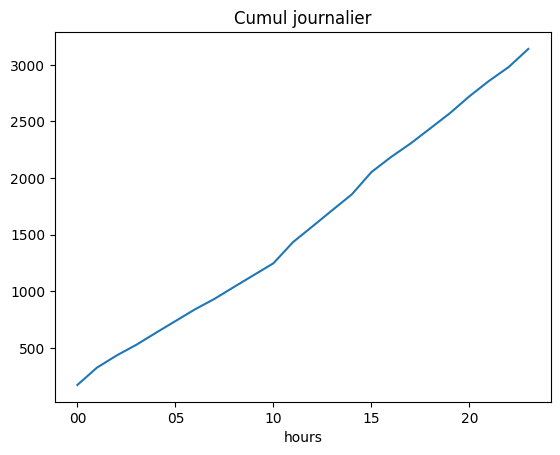

In [2116]:
# progression sans surprise
grp_by_dayhours.loc['05/11/24']['cumsum'].plot()
plt.title('Cumul journalier')

Text(0.5, 1.0, 'Variation horaire')

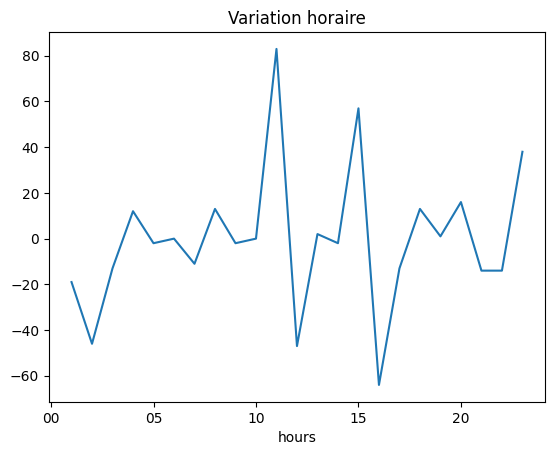

In [2117]:
# plus parlant
grp_by_dayhours.loc['05/11/24']['diff'].plot()
plt.title(r'Variation horaire')

In [2118]:
# count number of days since 21/08/2023
# https://stackoverflow.com/questions/45972388/count-my-multi-index-length-in-a-dataframe-pandas
n = len(grp_by_dayhours.index.levels[0].unique())
# or
n = len(grp_by_dayhours.index.levels[0])
# or
n = grp_by_dayhours.index.levshape[0]  # levshape -> (371,24)
n

303

In [2119]:
df_grp.tail(n)['kWh'].describe()


count    303.000000
mean       3.300330
std        0.754152
min        1.783000
25%        3.098000
50%        3.465000
75%        3.794500
max        4.810000
Name: kWh, dtype: float64

In [2120]:
maxday = df_grp.tail(n)['kWh'].idxmax()

In [2121]:
n, np.nanmean(df_grp.tail(n))

(303, np.float64(3.3003300330033003))

Text(0.5, 1.0, '303 days')

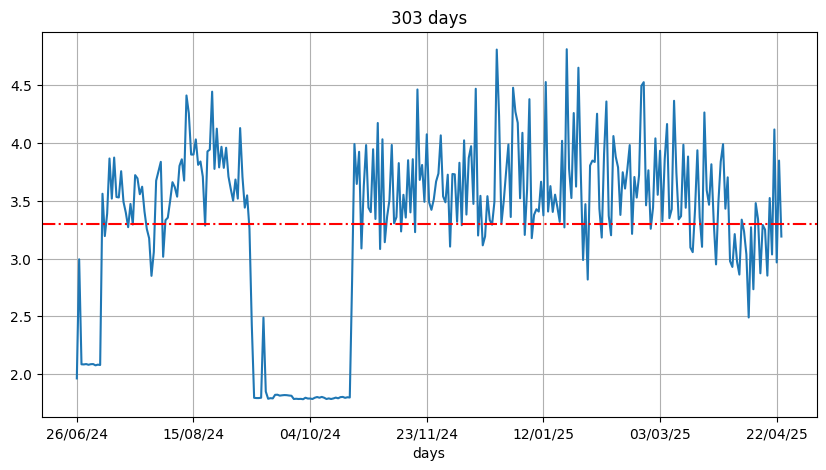

In [2122]:
# show conso in span 
span = n
df_grp.tail(span)['kWh'].plot(figsize=(10, 5), layout='tight', grid=True)
plt.axhline(y=np.nanmean(df_grp.tail(span)),c='red', ls='-.',label='moyenne')
plt.title(f'{span} days')

Text(0.5, 1.0, '100 days')

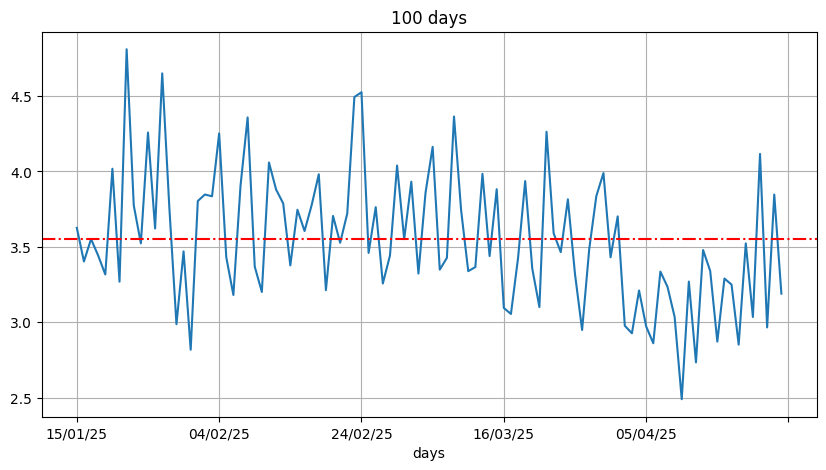

In [2123]:
# show conso in span 
span = 100
df_grp.tail(span)['kWh'].plot(figsize=(10, 5), layout='tight', grid=True)
plt.axhline(y=np.nanmean(df_grp.tail(span)),c='red', ls='-.',label='moyenne')
plt.title(f'{span} days')

In [2124]:
np.nanmean(df_grp.tail(span))

np.float64(3.55185)

In [2125]:
df_grp['kWh']

days
26/06/24    1.963
27/06/24    2.993
28/06/24    2.085
29/06/24    2.084
30/06/24    2.087
            ...  
20/04/25    3.035
21/04/25    4.116
22/04/25    2.966
23/04/25    3.847
24/04/25    3.190
Name: kWh, Length: 303, dtype: float64

In [2126]:
df_grp.describe()

,kWh
count,303.000000
mean,3.300330
std,0.754152
min,1.783000
25%,3.098000
50%,3.465000
75%,3.794500
max,4.810000


array([[<Axes: title={'center': 'kWh'}>]], dtype=object)

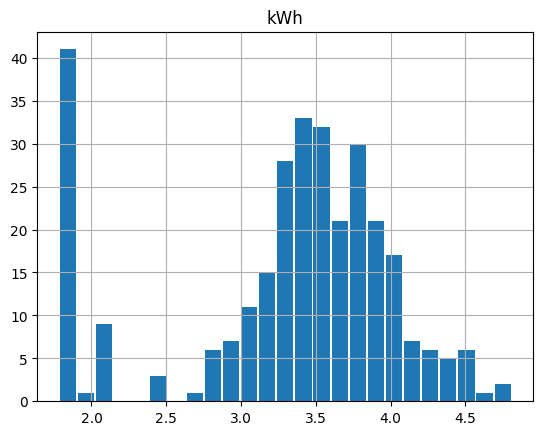

In [2127]:
# répartition des consos de 1 à 5 kWh par jour
# https://matplotlib.org/stable/api/_as_gen/matplotlib.pyplot.hist.html
# histtype{'bar', 'barstacked', 'step', 'stepfilled'}, default: 'bar'
df_grp.hist(bins=25, density=False, histtype='bar',rwidth=0.9, align='mid')

In [2128]:
df_grp.tail(span)['kWh']

days
15/01/25    3.626
16/01/25    3.403
17/01/25    3.552
18/01/25    3.442
19/01/25    3.317
            ...  
20/04/25    3.035
21/04/25    4.116
22/04/25    2.966
23/04/25    3.847
24/04/25    3.190
Name: kWh, Length: 100, dtype: float64

# Conso par heure

In [2129]:
day

'24/04/25'

In [2130]:
grp_by_dayhours.loc[day]

,kWh,cumsum,diff
hours,,,
00,125,125,NaN
01,104,229,-21.0
02,104,333,0.0
03,101,434,-3.0
04,102,536,1.0
05,101,637,-1.0
06,113,750,12.0
07,179,929,66.0
08,125,1054,-54.0


In [2131]:
# select a day to plot
day = '02/07/24'
day = today
len(grp_by_dayhours.loc[day])


22

In [2132]:
l = range(1,len(grp_by_dayhours.loc[day])+1)
l

range(1, 23)

In [2133]:
grp_by_dayhours.loc[day,'days'] = l #ist(1,len(grp_by_day.loc[day])+1)

In [2134]:
grp_by_dayhours.loc[day,'days'].values

array([ 1.,  2.,  3.,  4.,  5.,  6.,  7.,  8.,  9., 10., 11., 12., 13.,
       14., 15., 16., 17., 18., 19., 20., 21., 22.])

In [2135]:
grp_by_dayhours.loc[day,'days']

hours
00     1.0
01     2.0
02     3.0
03     4.0
04     5.0
05     6.0
06     7.0
07     8.0
08     9.0
09    10.0
10    11.0
11    12.0
12    13.0
13    14.0
14    15.0
15    16.0
16    17.0
17    18.0
18    19.0
19    20.0
20    21.0
21    22.0
Name: days, dtype: float64

In [2136]:
### ????????????????????????
grp_by_dayhours.loc[day,'days'] = grp_by_dayhours.loc[day,'days'].values.astype('int64')

In [2137]:
grp_by_dayhours.loc[day].info()

<class 'pandas.core.frame.DataFrame'>
Index: 22 entries, 00 to 21
Data columns (total 4 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   kWh     22 non-null     int64  
 1   cumsum  22 non-null     int64  
 2   diff    21 non-null     float64
 3   days    22 non-null     float64
dtypes: float64(2), int64(2)
memory usage: 880.0+ bytes


In [2138]:
grp_by_dayhours.loc[day,'days']

hours
00     1.0
01     2.0
02     3.0
03     4.0
04     5.0
05     6.0
06     7.0
07     8.0
08     9.0
09    10.0
10    11.0
11    12.0
12    13.0
13    14.0
14    15.0
15    16.0
16    17.0
17    18.0
18    19.0
19    20.0
20    21.0
21    22.0
Name: days, dtype: float64

In [2139]:
day

'24/04/25'

In [2140]:
grp_by_dayhours.loc[day]

,kWh,cumsum,diff,days
hours,,,,
00,125,125,NaN,1.0
01,104,229,-21.0,2.0
02,104,333,0.0,3.0
03,101,434,-3.0,4.0
04,102,536,1.0,5.0
05,101,637,-1.0,6.0
06,113,750,12.0,7.0
07,179,929,66.0,8.0
08,125,1054,-54.0,9.0


In [2141]:
kwh = grp_by_dayhours.loc[day][['kWh']]
np.sum(kwh)[0]


c:\Users\jeand\AppData\Local\Programs\Python\Python313\Lib\site-packages\numpy\_core\fromnumeric.py:84: FutureWarning: The behavior of DataFrame.sum with axis=None is deprecated, in a future version this will reduce over both axes and return a scalar. To retain the old behavior, pass axis=0 (or do not pass axis)
  return reduction(axis=axis, out=out, **passkwargs)
C:\Users\jeand\AppData\Local\Temp\ipykernel_15908\3891495459.py:2: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  np.sum(kwh)[0]


np.int64(3190)

c:\Users\jeand\AppData\Local\Programs\Python\Python313\Lib\site-packages\numpy\_core\fromnumeric.py:84: FutureWarning: The behavior of DataFrame.sum with axis=None is deprecated, in a future version this will reduce over both axes and return a scalar. To retain the old behavior, pass axis=0 (or do not pass axis)
  return reduction(axis=axis, out=out, **passkwargs)


Text(0.5, 1.0, '24/04/25: kWh    3190\ndtype: int64')

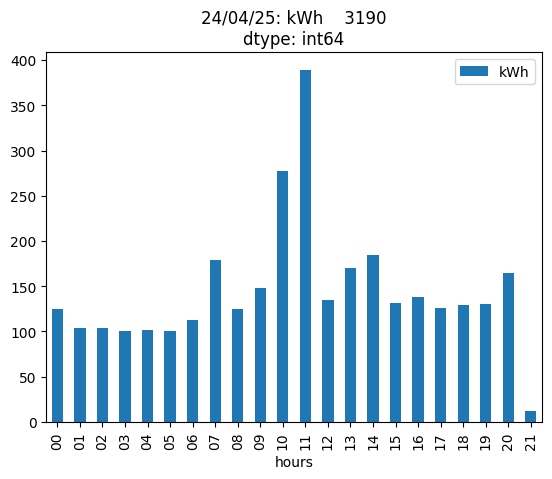

In [2142]:
kwh.plot.bar()
plt.title(f'{day}: {np.sum(kwh)}')

In [2143]:
grp_by_dayhours.loc[day].index

Index(['00', '01', '02', '03', '04', '05', '06', '07', '08', '09', '10', '11',
       '12', '13', '14', '15', '16', '17', '18', '19', '20', '21'],
      dtype='object', name='hours')

# Conso du jour


In [2144]:

grp_by_dayhours.count()

kWh       7262
cumsum    7262
diff      6959
days        22
dtype: int64

'22/01/25'

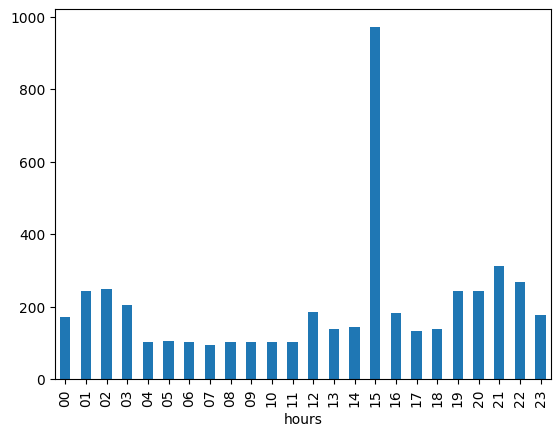

In [2145]:
#day = '09/09/24'
day = maxday
#day = today
grp_by_dayhours.loc[day].kWh.plot(kind='bar')
maxday

In [2146]:
def conso_by_hour(day):
    global data
    # conso by hour
    #data = groupedbyhour.count().kWh
    data = grp_by_dayhours.loc[day].kWh

    # len(groupedbyhour)
    x = np.arange(1,len(data)+1)
    ymax = max(data)+5
    #groupedbyhour.count().plot(grid=True,xticks=x)
    fig, ax = plt.subplots(figsize=(8, 5), facecolor='darkcyan')

    plt.bar(x,data)
    #plt.grid()
    plt.tight_layout()
    plt.title(f'Conso by hour (W) {day} - Total {sum(data)}')
    plt.xlim(0,len(x)+1)
    #plt.xticks(rotation=30);
    #plt.ylim(0,ymax)

    rects = ax.patches

    # Make some labels.
    labels = [f"{i}" for i in data]
    fontfamily = {'calibri', 'serif', 'sans-serif', 'cursive', 'fantasy', 'monospace'}
    for rect, label in zip(rects, labels):
        height = rect.get_height()
        ax.text(
            rect.get_x() + rect.get_width() / 2, height + 3, label, ha="center", va="bottom",
            fontfamily=fontfamily, fontsize=10, fontweight='bold', color='red'
        )


# 100 days

In [2147]:
df_grp.tail(7)['kWh']

days
18/04/25    2.852
19/04/25    3.523
20/04/25    3.035
21/04/25    4.116
22/04/25    2.966
23/04/25    3.847
24/04/25    3.190
Name: kWh, dtype: float64

Total= 355.185 , Moyenne= 3.55185


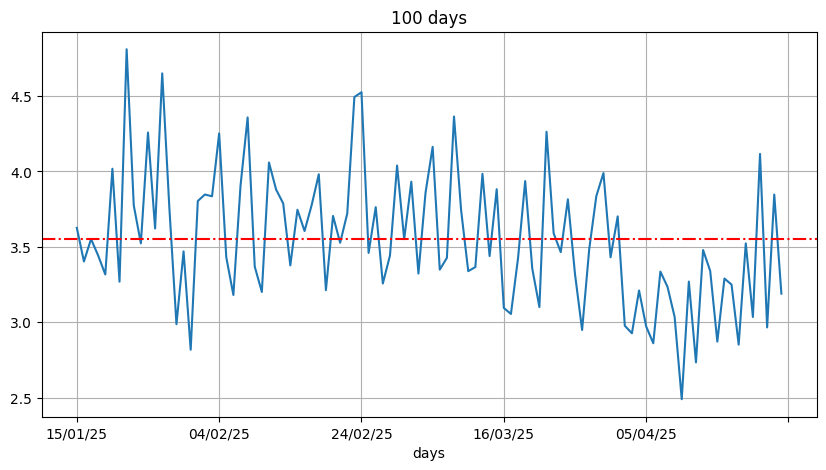

In [2148]:
# show conso in span 
span = 100
df_grp.tail(span)['kWh'].plot(figsize=(10, 5), layout='tight', grid=True)
plt.axhline(y=np.nanmean(df_grp.tail(span)),c='red', ls='-.',label='moyenne')
plt.title(f'{span} days')

print('Total=',sum(df_grp.tail(span)['kWh']),', Moyenne=',np.nanmean(df_grp.tail(span)))

In [2149]:
#import timeit
#start = timeit.timeit()
#print("hello")
end = time.time()
print(end - start)

143.12777471542358


# Today

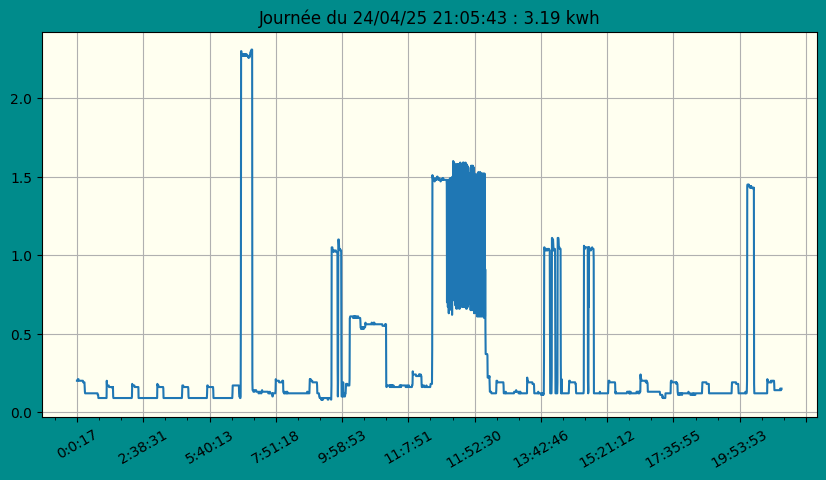

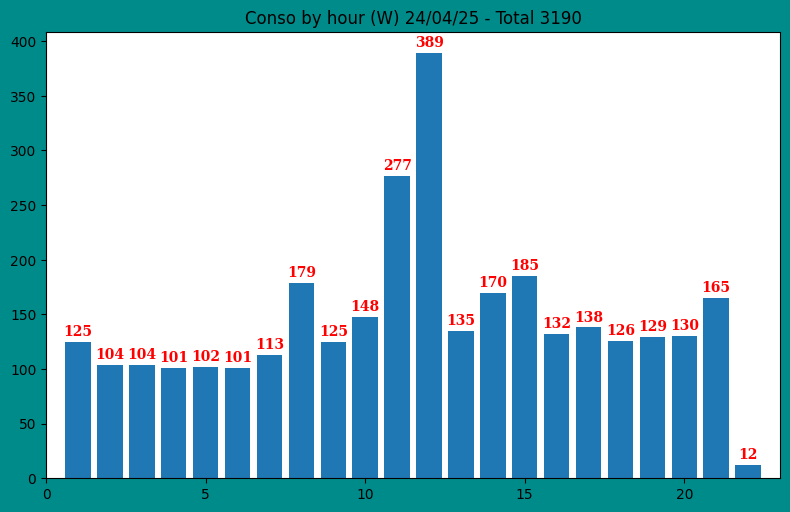

In [2150]:
show(today,bgcolor='ivory')
conso_by_hour(today)

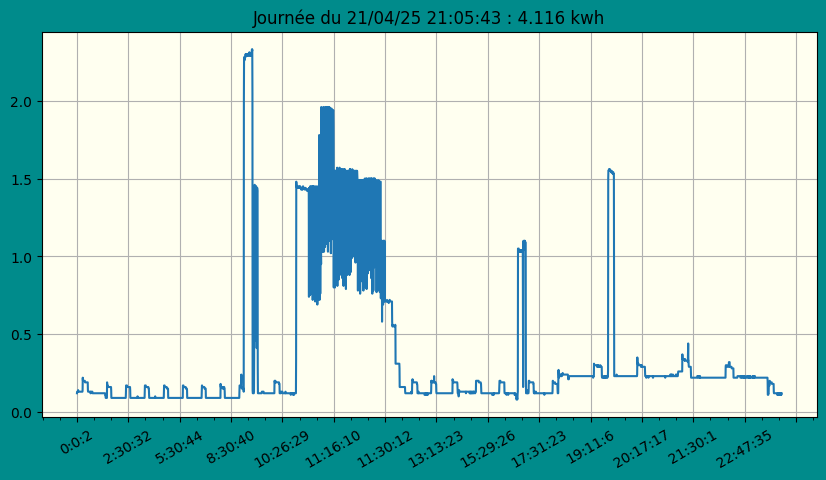

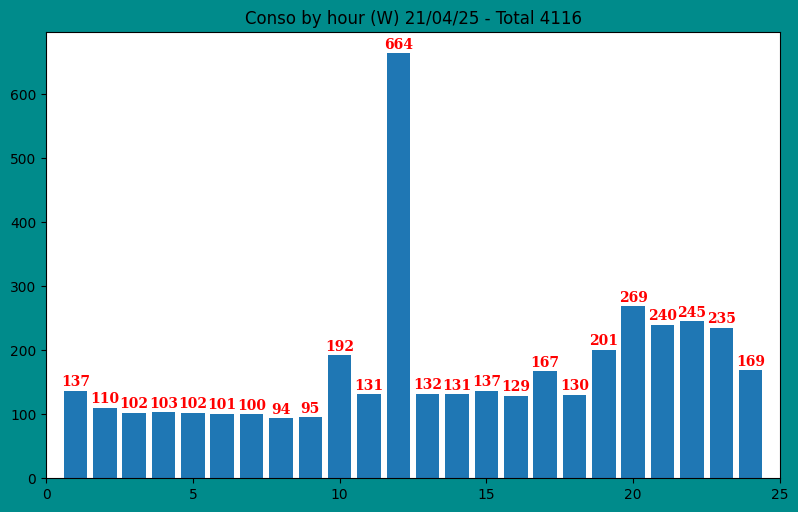

In [2151]:
day = '21/04/25' # 21/04/25 cuisine midi et télé le soir 4.115 kWh
day, show(day,bgcolor='ivory')
conso_by_hour(day)

22/01/25


(None, 4810)

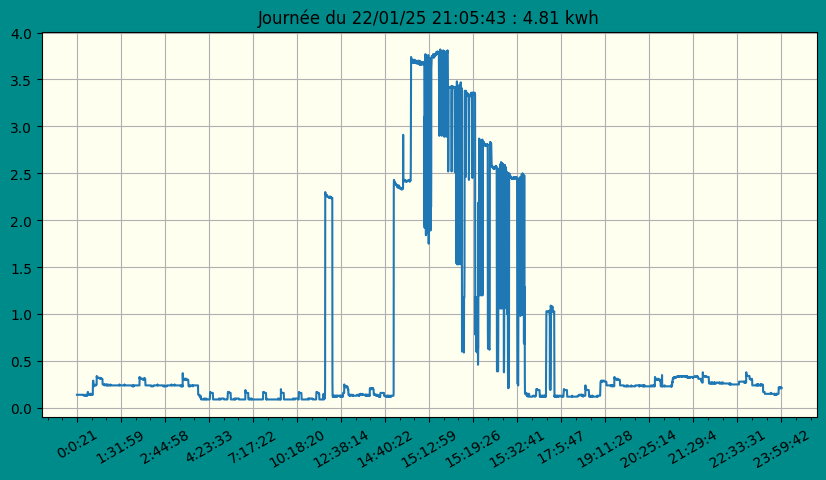

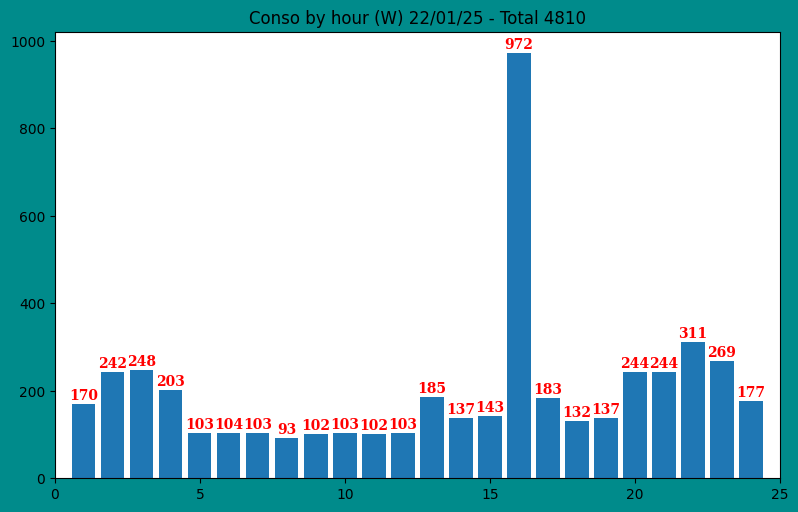

In [2152]:
print(maxday)
# retour vietnam 22/10/2024
#day = '22/10/24'
day = maxday
day, show(day,bgcolor='ivory')
conso_by_hour(day),sum(data)

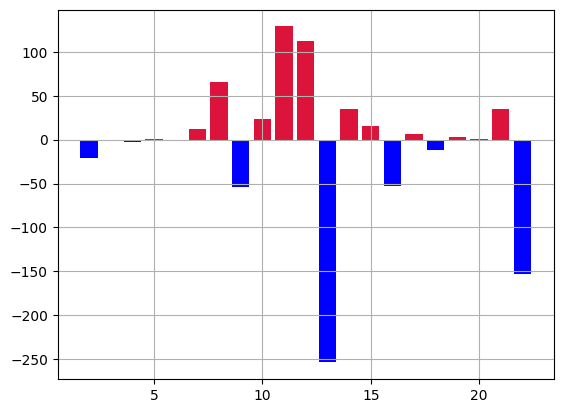

In [2153]:
diff = grp_by_dayhours.loc[today]
diff

x = np.arange(1,len(diff)+1)

plt.bar(x,diff['diff'], color=np.where(diff['diff'] > 0, 'crimson', 'blue'))
plt.grid()

<Axes: xlabel='hours'>

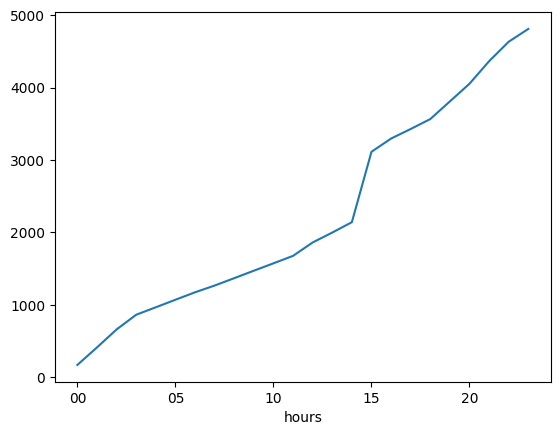

In [2154]:
data.cumsum().plot()


<Axes: xlabel='hours'>

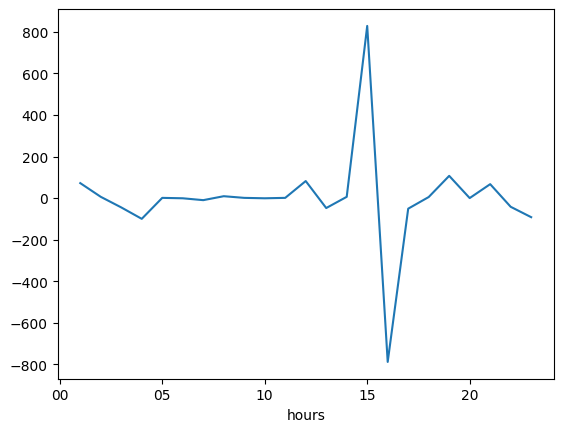

In [2155]:
# evolution par heure
data.diff().plot()

In [2156]:
data.diff().describe()

count     23.000000
mean       0.304348
std      249.093527
min     -789.000000
25%      -43.500000
50%        1.000000
75%        7.500000
max      829.000000
Name: kWh, dtype: float64

<Axes: >

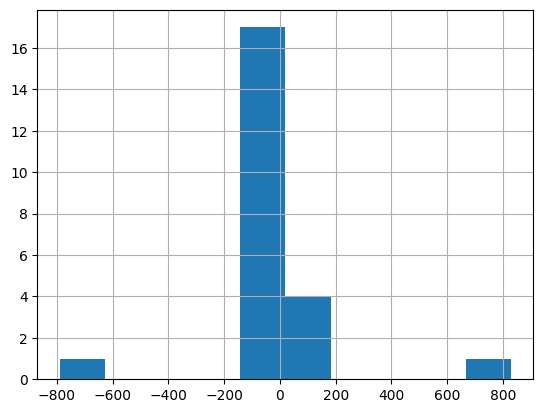

In [2157]:
data.diff().hist()

# Test sauvegarde

# list files in current directory


In [2158]:
import os
os.listdir(path='.')

['linear combination of atomic orbitals.ipynb',
 'loi_pareto.ipynb',
 'Lotka_Volterra_model.ipynb',
 'bitcoin_api.ipynb',
 'pencil_sketch.ipynb',
 'sample.json',
 'tricks.ipynb',
 'pandas_course2.ipynb',
 'socket_server.ipynb',
 'tree_minmax.ipynb',
 'amlich_data.py',
 'decimals_pi_plot.ipynb',
 'conso_jour.csv',
 'Mass_Spring_Damper.jpg',
 'mills_primes.ipynb',
 'ligue1_pandas.ipynb',
 'primes2million.pkl',
 'socket_client.ipynb',
 'magic_tricks.ipynb',
 'magicdragon.ipynb',
 'rainbow_color.ipynb',
 'snake_game.ipynb',
 'sympy_fun.ipynb',
 'tqdm_benchmark.ipynb',
 'ligue1_2020_extended.txt',
 'pd_grp_plot.ipynb',
 'tkinter_scale_color.ipynb',
 'Dewpoint-RH-fr.svg.png',
 'read_xml.ipynb',
 'pi_from_collisions.ipynb',
 'mqtt_temp.ipynb',
 'sudoku_generator.ipynb',
 'onecall_issue.ipynb',
 'poo_chap10.ipynb',
 'table-indicateurs-open-data-france-2023-06-30-17h59.csv',
 'primes12million.pkl',
 'espace_de_phase.ipynb',
 'ipinfo_test.ipynb',
 'enigma_settings.json',
 '__pycache__',
 'test_c

# list store files csv


In [2159]:
res = []
# Iterate directory
for file in os.listdir('.'):
    # check only text files
    if file.endswith('.csv'):
        res.append(file)
        print(file)
#print(res)

conso_jour.csv
table-indicateurs-open-data-france-2023-06-30-17h59.csv
CAC40.csv
Nasdaq.csv
karaoke.csv
saturn_rings.csv
DowJones.csv
planete.csv
conso_par_jour.csv
8days.csv
SMSSpamCollection.csv
df_grp.csv
Ford.csv
Tesla.csv
Nikkei.csv
temp_humidity.csv
titanic.csv
data_temp16122022.csv
week.csv
Toyota.csv
Apple.csv
VNDUSD.csv
demain.csv
saturn_bodies.csv
conso_day_from_20230821.csv
WA_Fn-UseC_-Telco-Customer-Churn.csv
ligue1_2020_27.csv
table-indicateurs-open-data-dep-2023-06-30-17h59.csv
conso_data.csv
EURUSD.csv
df.csv


('22/01/25', None)

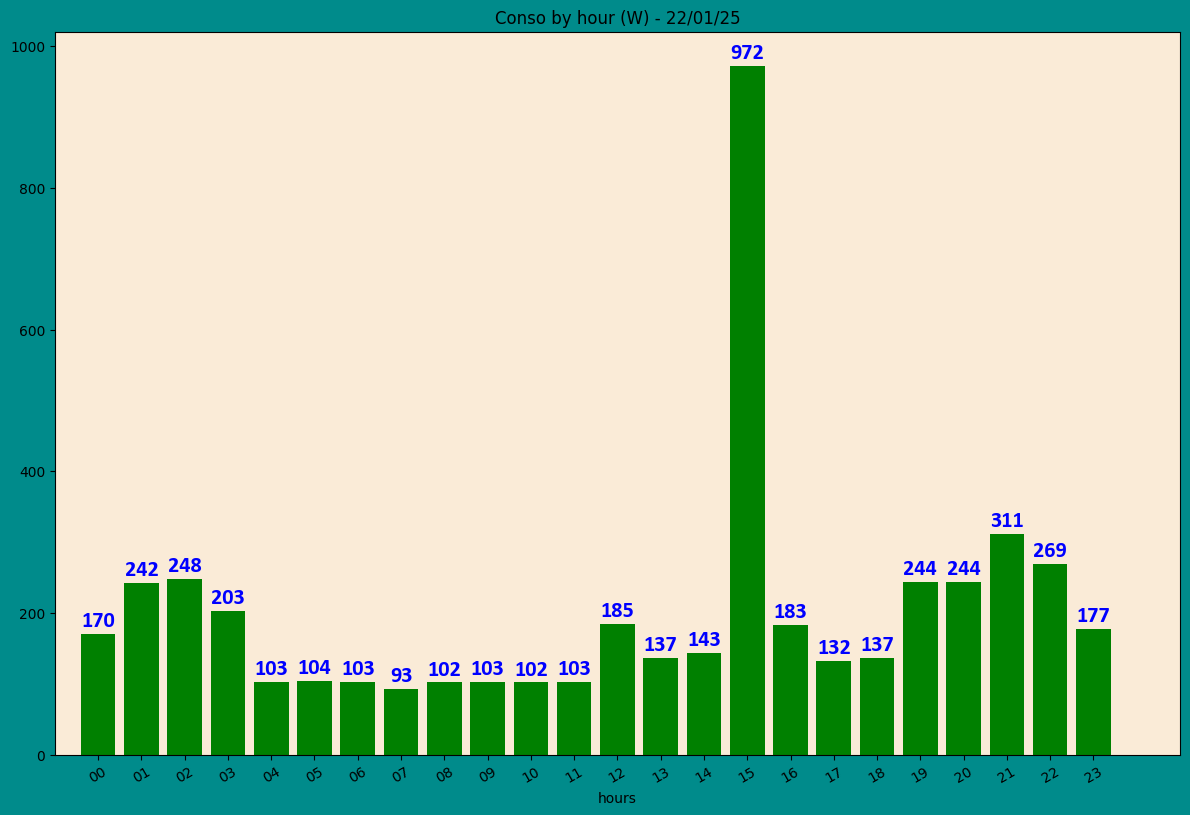

In [2160]:
day,conso_byhour(day)

In [2161]:
# save to file
import pickle
path = r'../consobyhour.pkl'
with open(path,'wb') as file:
    pickle.dump(data, file)

# plot any day


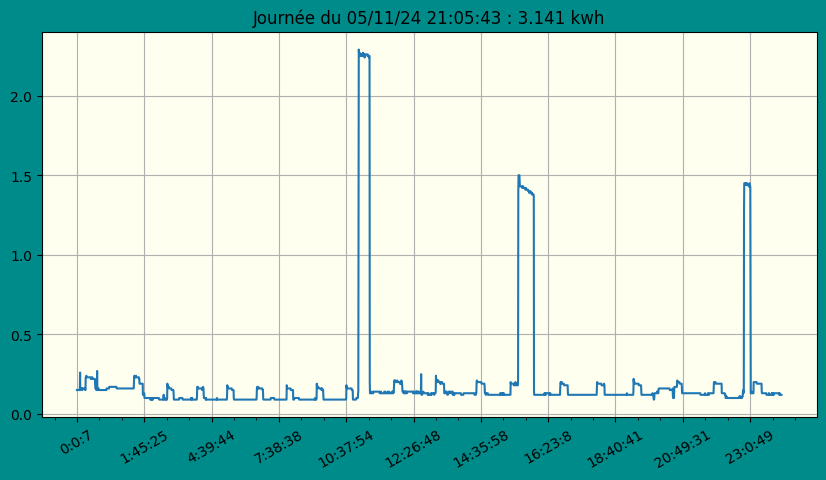

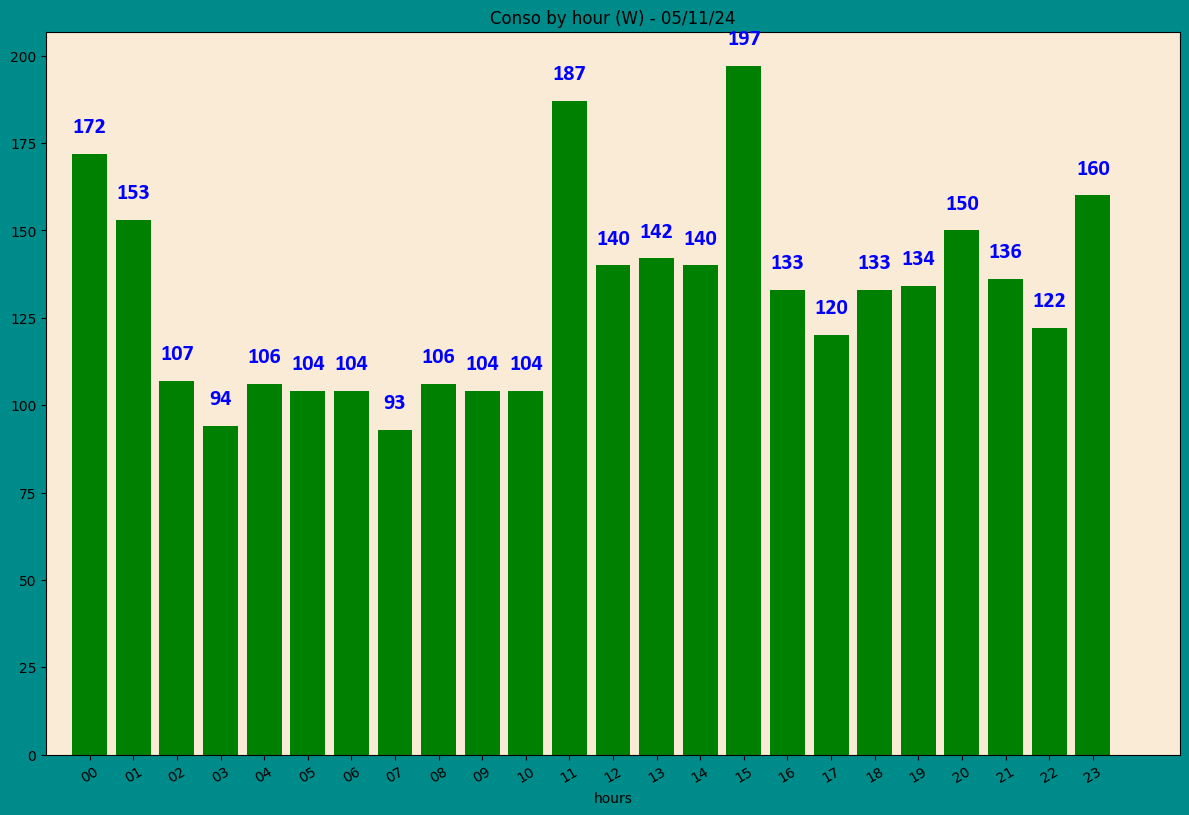

In [2162]:
day = '05/11/24'
#day = today
show(day,pltcolor='darkcyan')
conso_byhour(day)

In [2163]:
month

,day,hours,months,kWh
707116,01,00,2025-02,0.16
707117,01,00,2025-02,0.16
707118,01,00,2025-02,0.16
707119,01,00,2025-02,0.16
707120,01,00,2025-02,0.16
...,...,...,...,...
811612,28,23,2025-02,0.20
811613,28,23,2025-02,0.21
811614,28,23,2025-02,0.20
811615,28,23,2025-02,0.20


In [2164]:
month.describe()


,kWh
count,104501.000000
mean,0.334552
std,0.555051
min,0.090000
25%,0.120000
50%,0.140000
75%,0.190000
max,3.650000


array([[<Axes: title={'center': 'kWh'}>]], dtype=object)

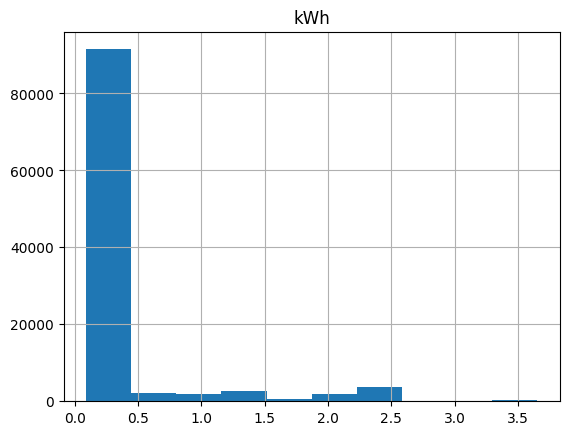

In [2165]:
month.hist()

<Axes: >

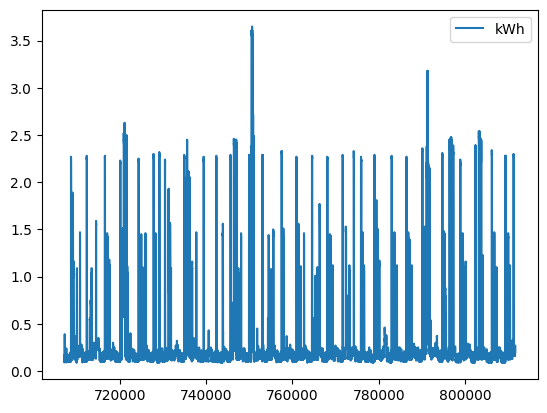

In [2166]:
month.plot()

In [2167]:
# index with max conso in this month
month.idxmax().kWh

np.int64(750648)

In [2168]:
# plot month day max conso (télévision de 11h à 23h)
day_idx = month.idxmax()
#day = '27/10/2024'
day_idx

day       808175
hours     710710
months    707116
kWh       750648
dtype: int64

In [2169]:
#show(day,pltcolor='darkcyan')
#conso_byhour(day)

In [2170]:
grp_by_dayhours

kWh  cumsum   diff  days
days     hours                          
26/06/24 08      72      72    NaN   NaN
         09     108     180   36.0   NaN
         10     106     286   -2.0   NaN
         11     113     399    7.0   NaN
         12     152     551   39.0   NaN
...             ...     ...    ...   ...
24/04/25 17     126    2754  -12.0  18.0
         18     129    2883    3.0  19.0
         19     130    3013    1.0  20.0
         20     165    3178   35.0  21.0
         21      12    3190 -153.0  22.0

[7262 rows x 4 columns]

In [2171]:
month

,day,hours,months,kWh
707116,01,00,2025-02,0.16
707117,01,00,2025-02,0.16
707118,01,00,2025-02,0.16
707119,01,00,2025-02,0.16
707120,01,00,2025-02,0.16
...,...,...,...,...
811612,28,23,2025-02,0.20
811613,28,23,2025-02,0.21
811614,28,23,2025-02,0.20
811615,28,23,2025-02,0.20


In [2172]:
month.idxmax()


day       808175
hours     710710
months    707116
kWh       750648
dtype: int64

In [2173]:
month.loc[month.idxmax().kWh]


day            12
hours          15
months    2025-02
kWh          3.65
Name: 750648, dtype: object

In [2174]:
grp_by_dayhours.loc[['28/02/25']].kWh

days      hours
28/02/25  00       156
          01       115
          02       100
          03       110
          04       111
          05       111
          06        98
          07       110
          08       111
          09       109
          10       170
          11       145
          12       148
          13       146
          14       188
          15       146
          16       197
          17       157
          18       150
          19       144
          20       156
          21       226
          22       173
          23       165
Name: kWh, dtype: int64

In [2175]:
max_hour = grp_by_dayhours.loc[['28/02/25']].kWh.idxmax()[1]
max_hour

'21'

<Axes: xlabel='days,hours'>

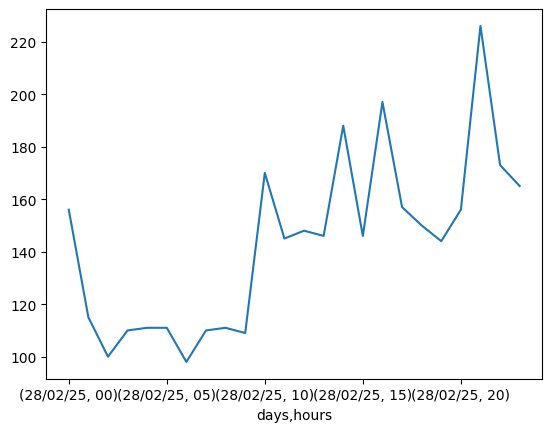

In [2176]:
grp_by_dayhours.loc[['28/02/25']].kWh.plot()#.idxmax()

In [2177]:
grp_by_dayhours.columns

Index(['kWh', 'cumsum', 'diff', 'days'], dtype='object')

In [2178]:
# diff
# plt.plot(grp_by_dayhours.loc[month.idxmax()]['diff'],label=grp_by_dayhours.columns[2])
# plt.legend()

In [2179]:
# cumsum
# plt.plot(grp_by_dayhours.loc[month.idxmax()]['cumsum'],label=grp_by_dayhours.columns[1])
# plt.legend()

In [2180]:
# 41 s
# file to big to git sync

# create .gitignore
filename=r'../conso_data.csv'
#conso_data.to_csv(filename)
#43.6s size 140128 kB